# Monte Carlo Study of Ferro-magnetism using an Ising Model


The goal of this simulation is to run a statistical model simulating the evolution of magnetism as a function of material temperature. 
Since the emergence of magnetism is attributed to the contribution of a great many small atomic magnetic dipoles a statistical method is to be utilised.



### The Ising model


The subject of of this project will be statistical in nature, and hence a basic understanding of Monte Carlo methods and random number algorithms will be necessary.
## Monte Carlo Methods and the Ising model
Numerical computations which utilise random numbers are called Monte Carlo methods after a famous gambling hotspot in Monaco, used as a code word for the method, which, at the time, was a military secret[1]. The obvious applications of such methods are in stochastic physics: e.g., statistical thermodynamics. However, there are other, less obvious, applications including the evaluation of multi-dimensional integrals. The modern version of the Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, and heavily influenced by Enrico Fermi, John von Neumann and Nicholas Metropolis [1].

Instead of a general discussion of Monte Carlo methods, we shall restrict our attention to a specific kind of monte carlo method calle the **Metropolis Algorithm**. The Metropolis algorithm is a simple and widely used approach to generate the canonical ensemble in statistical mechanics. It is especially convenient to explain (and to implement) for an Ising model. The algorithm has the following steps.

1. Start with some spin configuration $\left\{s_i\right\}$.
2. Randomly choose a spin $s_i$
3. Attempt to flip it, *i.e.* $s_ \rightarrow − s_i$ (trial).
4. Compute the energy change $\Delta E$ and magnetization change $\Delta m$ due to this flip. This calculation will only involve the nearest neighbour spins.
    * If $\Delta E \leq 0$, accept the trial.
    * If $\Delta E > $ 0, accept the trial with probability $p \sim \exp{\left(-\beta\Delta E\right)}$.
5. If trial is rejected, put the spin back, *i.e.*: $s_ \rightarrow − s_i$
6. Repeat the above $N$- times, where $N$ is the total number of spins in the model. This is one monte carlo step. Calculate the cumulative change in energy and magnetization.
7. Keep repeating Monte Carlo steps until the time-averaged energy and magnetization appear to stabilize. That will be the thermal equilibrium point.


## References

1. Metropolis, N. (1987). ["The beginning of the Monte Carlo method"](https://dasher.wustl.edu/chem478/reading/lascience-14-125-87.pdf). Los Alamos Science (1987 Special Issue dedicated to Stanislaw Ulam): 125–130.

2. [http://micro.stanford.edu/~caiwei/me334/Chap12_Ising_Model_v04.pdf]

3. [https://github.com/bdhammel/ising-model]

4. [https://share.cocalc.com/share/bb76377ee6823f7155a629e6f072f30d7c0b956f/Project_IsingModel/Project_IsingModel.ipynb?viewer=share]

In [1]:
import numpy as np

def rand_latt(shape, prob=0.5):
    nrows, ncols = shape
    latt = np.random.choice(a=[-1, 1], size=shape, p=[prob, 1-prob])
    return latt

normal_latt = lambda shape: np.ones(shape)

#Credited to Alex McFarlane @ https://flipdazed.github.io/
class Periodic_Lattice(np.ndarray):
    """Creates an n-dimensional ring that joins on boundaries w/ numpy
    
    Required Inputs
        array :: np.array :: n-dim numpy array to use wrap with
    
    Only currently supports single point selections wrapped around the boundary
    """
    def __new__(cls, input_array, lattice_spacing=None):
        """__new__ is called by numpy when and explicit constructor is used:
        obj = MySubClass(params) otherwise we must rely on __array_finalize
         """
        # Input array is an already formed ndarray instance
        # We first cast to be our class type
        obj = np.asarray(input_array).view(cls)
        
        # add the new attribute to the created instance
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        
        # Finally, we must return the newly created object:
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        """ ndarray.__new__ passes __array_finalize__ the new object, 
        of our own class (self) as well as the object from which the view has been taken (obj). 
        See
        http://docs.scipy.org/doc/numpy/user/basics.subclassing.html#simple-example-adding-an-extra-attribute-to-ndarray
        for more info
        """
        # ``self`` is a new object resulting from
        # ndarray.__new__(Periodic_Lattice, ...), therefore it only has
        # attributes that the ndarray.__new__ constructor gave it -
        # i.e. those of a standard ndarray.
        #
        # We could have got to the ndarray.__new__ call in 3 ways:
        # From an explicit constructor - e.g. Periodic_Lattice():
        #   1. obj is None
        #       (we're in the middle of the Periodic_Lattice.__new__
        #       constructor, and self.info will be set when we return to
        #       Periodic_Lattice.__new__)
        if obj is None: return
        #   2. From view casting - e.g arr.view(Periodic_Lattice):
        #       obj is arr
        #       (type(obj) can be Periodic_Lattice)
        #   3. From new-from-template - e.g lattice[:3]
        #       type(obj) is Periodic_Lattice
        # 
        # Note that it is here, rather than in the __new__ method,
        # that we set the default value for 'spacing', because this
        # method sees all creation of default objects - with the
        # Periodic_Lattice.__new__ constructor, but also with
        # arr.view(Periodic_Lattice).
        #
        # These are in effect the default values from these operations
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        """returns periodic lattice index 
        for a given iterable index
        
        Required Inputs:
            index :: iterable :: one integer for each axis
        
        This is NOT compatible with slicing
        """
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


class ising_metropolis:
    """Creates an n-dimensional context for performing numerical simulations
    of the classical Ising model using the metropilis algorithm.    
    Required Inputs
        lattice :: np.array :: n-dim numpy array of Ising spins, initialized.
    
    Optional Inputs
        k       :: integer  :: number of nearest neighbors in the model, default=1
        J       :: iterable :: array of hopping amplitudes, size must equal k, default=[1.0]
        h       :: float    :: longitudinal field, default=0
        verbose :: boolean  :: verbose output, default=True
    Periodic boundary conditions are ensured using the 'Periodic_Lattice' object coded
    in the corresponding class above
    
    Note that this class will only work for lattices where long range hoppings are defined 
    on the lattice graph, and not on the continuum.
    Ref: http://micro.stanford.edu/~caiwei/me334/Chap12_Ising_Model_v04.pdf
    """
    def __init__(self, lattice, k=1, J=[1.0], h=0, verbose=True):
        self.lattice = Periodic_Lattice(lattice)
        self.k = k
        self.J = J
        self.h = h
        self.verbose = verbose
            
    def rand_idx(self):
        """Randomly chooses a set of lattice indices.
        """
        indices = [np.random.randint(0, high=ndim) for ndim in self.lattice.lattice_shape]
        return indices
   
    def flip_spin(self, indices):
        """Flips an Ising spin in the lattice. Takes indices as argument.
        """
        self.lattice[indices] *= -1

    def comb_spinstate(self, indices):
        """A key element of this model is calculating the combined spin state of the k-nearest 
        neighbours around a given lattice point . Returns the combined spin state local to '
        that point
        TODO: https://github.com/patvarilly/periodic_kdtree , https://docs.scikit-nano.org/dev/api/sknano.core.analysis.PeriodicKDTree.html
        """
        
        return None
    
    def draw(self, plotter, draw_size=(25,1), **kwargs):
        """If the lattice is 1 or 2 dimensional, then draws it
        
        Required Inputs
        plotter :: matplotlib object or axis
        """
        if len(self.lattice.lattice_shape) > 2:
            raise ValueError("Lattice must be 1 or 2 dimensional, not %d."%self.lattice.lattice_shape)
        l, w = draw_size
        fig = plt.figure()
        fig.set_size_inches(l,w)
        plotter.axis('off')
        plotter.imshow(self.lattice, **kwargs)
        plotter.show()
    
    def evolve(self):
        """Carries out the metropolis evolution
        TODO:https://share.cocalc.com/share/bb76377ee6823f7155a629e6f072f30d7c0b956f/Project_IsingModel/Project_IsingModel.ipynb?viewer=share
        """
        return None

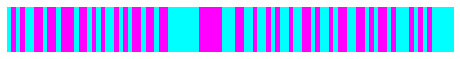

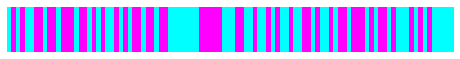

In [3]:
#Test values for rendering ising model in 1d 
import matplotlib.pyplot as plt
%matplotlib inline
# 1 dimensional
nspins = 100
image_size = (8, 30) #This is in inches

I_1d = ising_metropolis(rand_latt((1, nspins)))

I_1d.draw(plt, draw_size=image_size, cmap = 'cool', interpolation='nearest', aspect=10)

I_1d.flip_spin(I_1d.rand_idx())

I_1d.draw(plt, draw_size=image_size, cmap = 'cool', interpolation='nearest', aspect=10)

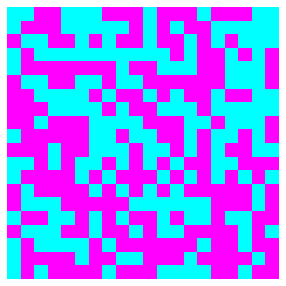

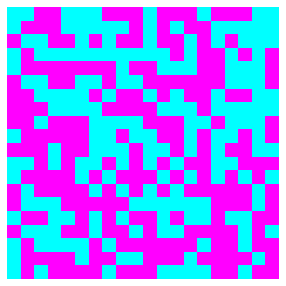

In [4]:
#Test values for rendering ising model in 2d 

# 2 dimensional
spinshape = (20, 20)
image_size = (5, 5) #This is in inches
image_aspect = 1 #Adjust this with nspins

I_2d = ising_metropolis(rand_latt(spinshape))

I_2d.draw(plt, draw_size=image_size, cmap = 'cool', interpolation='nearest', aspect=1)

I_2d.flip_spin(I_2d.rand_idx())

I_2d.draw(plt, draw_size=image_size, cmap = 'cool', interpolation='nearest', aspect=1)